In [ ]:
!pip install pandas matplotlib seaborn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


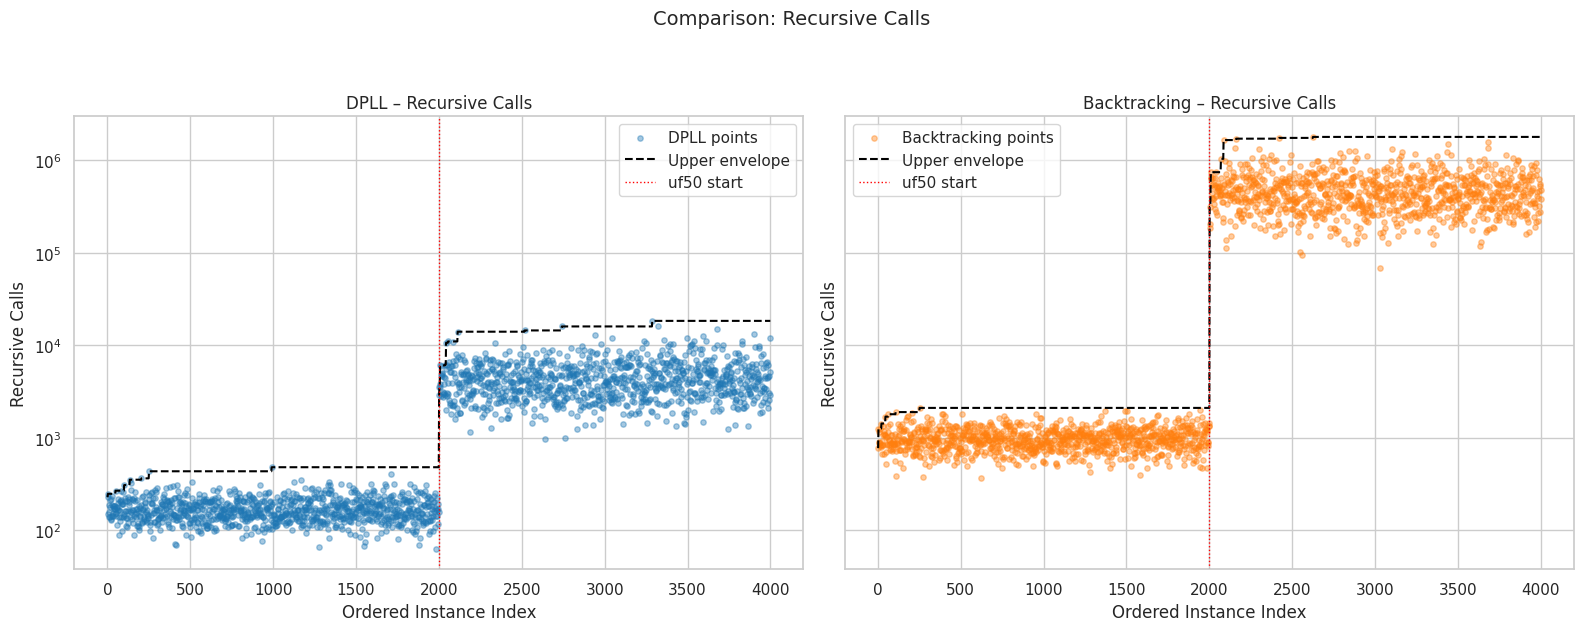

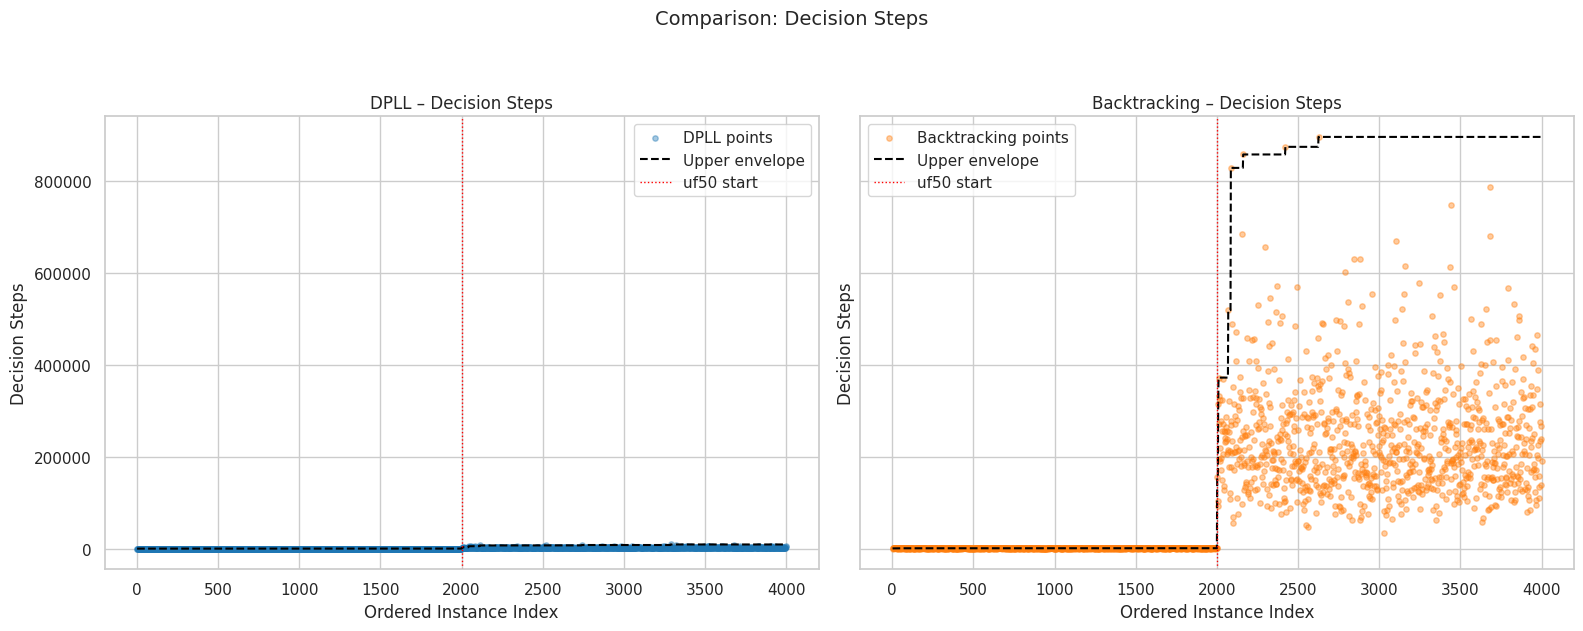

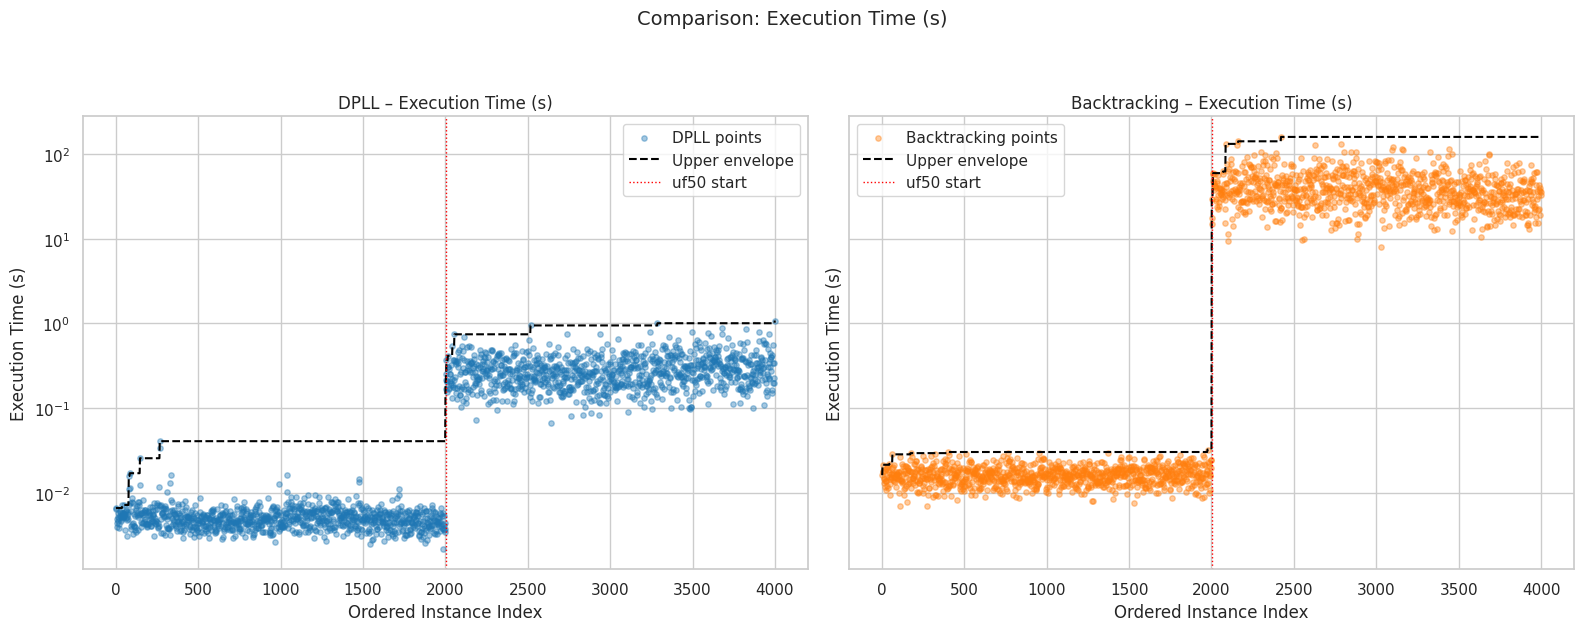

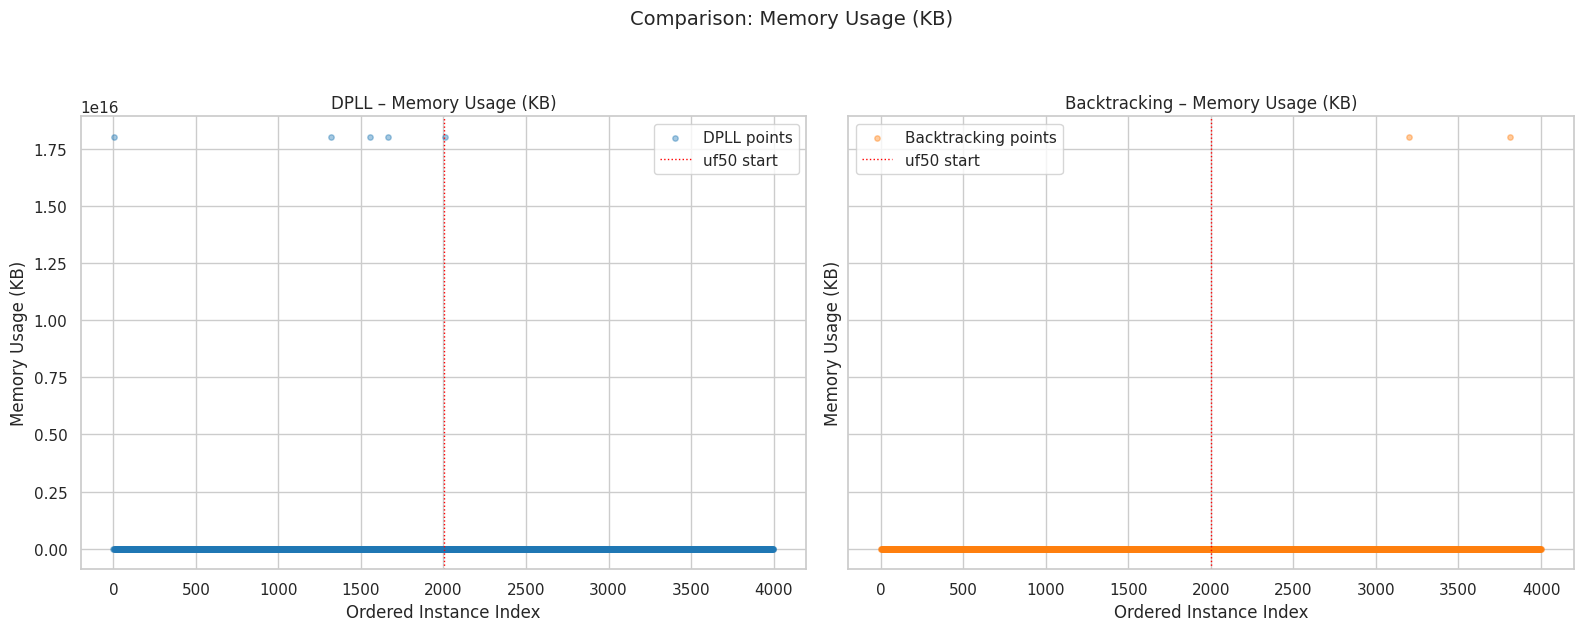

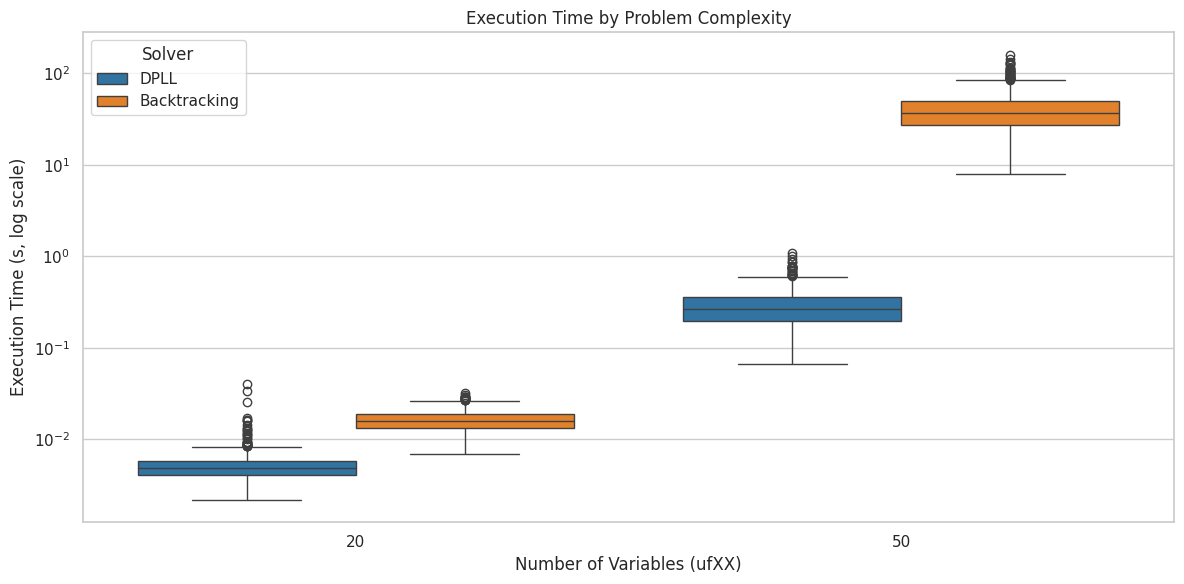

In [ ]:
# --- 1. Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- 2. Import necessary libraries ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# --- 3. General plotting configuration ---
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

# --- 4. Paths to your CSV files on Drive ---
file_results = '/content/drive/MyDrive/Colab Notebooks/Solver_Results.csv'
file_metrics = '/content/drive/MyDrive/Colab Notebooks/NumberofRecursiveCalls_DecisionSteps_Solver.csv'

# --- 5. Check for file existence ---
for f in (file_results, file_metrics):
    if not os.path.exists(f):
        raise FileNotFoundError(f"Missing file: {f}")

# --- 6. Load data ---
df_results = pd.read_csv(file_results, encoding='latin1')
df_metrics = pd.read_csv(file_metrics, encoding='latin1')

# --- 7. Preprocessing & merge ---
# rename for consistency
df_results = df_results.rename(columns={
    'Time': 'ExecutionTime',
    'AllocBytes(KB)': 'MemoryUsage'
})
df_metrics = df_metrics.rename(columns={
    'Decision Steps': 'DecisionSteps',
    'Number of Recursive Calls': 'NumRecCalls'
})

# extract complexity
for df in (df_results, df_metrics):
    df['Complexity'] = df['Group'].str.extract(r'uf(\d+)').astype(int)

# merge on keys
df_combined = df_results.merge(
    df_metrics,
    on=['Group','File','Solver','Complexity'],
    how='inner'
).sort_values(['Complexity','File']).reset_index(drop=True)

# sequence index
df_combined['Seq'] = df_combined.index + 1
# uf50 start marker
start_uf50 = df_combined.loc[df_combined['Complexity']==50, 'Seq'].min()

# plotting palette
palette = {'DPLL': '#1f77b4', 'Backtracking': '#ff7f0e'}

# --- 8. Plotting function ---
def plot_solver_comparison(metric_col, ylabel, log_scale=False, with_envelope=True):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    for ax, solver in zip(axes, ['DPLL', 'Backtracking']):
        subset = df_combined[df_combined['Solver']==solver]
        # raw points
        ax.scatter(
            subset['Seq'], subset[metric_col],
            s=15, alpha=0.4, color=palette[solver],
            label=f'{solver} points'
        )
        # upper envelope
        if with_envelope:
            env = subset[metric_col].cummax()
            ax.plot(
                subset['Seq'], env,
                color='black', linestyle='--', linewidth=1.5,
                label='Upper envelope'
            )
        # uf50 divider
        ax.axvline(start_uf50, color='red', linestyle=':', linewidth=1, label='uf50 start')
        ax.set_title(f'{solver} – {ylabel}')
        ax.set_xlabel('Ordered Instance Index')
        ax.set_ylabel(ylabel)
        if log_scale:
            ax.set_yscale('log')
        ax.legend()
    plt.suptitle(f'Comparison: {ylabel}', y=1.05, fontsize=14)
    plt.tight_layout()
    plt.show()

# --- 9. Generate plots ---
# 1) Recursive Calls (log scale)
plot_solver_comparison('NumRecCalls', 'Recursive Calls', log_scale=True)

# 2) Decision Steps
plot_solver_comparison('DecisionSteps', 'Decision Steps')

# 3) Execution Time (log scale)
plot_solver_comparison('ExecutionTime', 'Execution Time (s)', log_scale=True)

# 4) Memory Usage (no envelope)
plot_solver_comparison('MemoryUsage', 'Memory Usage (KB)', with_envelope=False)

# 5) Comparative boxplot for Complexity
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_combined, x='Complexity', y='ExecutionTime', hue='Solver', palette=palette)
plt.title('Execution Time by Problem Complexity')
plt.yscale('log')
plt.ylabel('Execution Time (s, log scale)')
plt.xlabel('Number of Variables (ufXX)')
plt.tight_layout()
plt.show()
